In [1]:
from dist_tools import *

import scipy
import math
import shapely
from shapely import wkt
from shapely.geometry import Point

from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.decomposition.pca import PCA

from scc import *  ## Nayuki minimum bounding circle, instead of miniball.

%matplotlib inline

In [2]:
def ctr(group, w):
    
    p = group[w]
    xctr = (group["x"] * p).sum() / p.sum()
    yctr = (group["y"] * p).sum() / p.sum()
    
    return Point([xctr, yctr])


def avg_interperson_distance(group):

    dist2 =  scipy.spatial.distance.cdist(group[["x", "y"]].as_matrix(),
                                          group[["x", "y"]].as_matrix(),
                                          metric = 'euclidean')

    interp_dist = np.dot(np.dot(group["pop"], dist2), group["pop"]) / \
                  np.dot(group["pop"][:,np.newaxis], group["pop"][np.newaxis,:]).sum()

    return interp_dist # * 0.000621371 # meters to miles


def normed_inertia(group, d, w):

    I = (group[d]**2 * group[w]).sum()
    In = group["area"].sum() * group[w].sum() / 2 / math.pi

    return In / I 


def R_circumscribing(group): return make_circle([xy for xy in zip(group["x"], group["y"])])[2]

def R_mean(group): return (group["area"] * group["dctr"]).sum() / group["area"].sum()
def R_dyn(group):  return np.sqrt((group["area"] * group["dctr"]**2).sum() / group["area"].sum())
def R_harm(group): return group["area"].sum() / (group["area"] / group["dctr"]).sum()

def get_points(x):
    
    l = x if type(x) is shapely.geometry.multipolygon.MultiPolygon else [x]
    
    pts = []
    for poly in l:
        for pt in poly.exterior.coords:
            pts.append(pt)
        for ir in poly.interiors:
            for pt in ir.coords:
                pts.append(pt)

    return pts


def get_lic(poly):
    
    # simp = poly.simplify(100)
    pts = get_points(poly)

    # print(pts)
    vor = Voronoi(pts)

    max_d2, lic_ctr, lic_r = 0, 0, 0
    for vtxi, vtx in enumerate(vor.vertices):

        if not poly.contains(Point(vtx)):
            continue

        region = [ri for ri, r in enumerate(vor.regions) if vtxi in r][0]

        source = None
        for pti, pt_reg in enumerate(vor.point_region):
            if region == pt_reg: 
                source = vor.points[pti]
                break

        d2 = (vtx[0] - source[0])**2 + (vtx[1] - source[1])**2

        if d2 > max_d2:

            max_d2 = d2
            lic_ctr, lic_r = tuple(vtx), math.sqrt(d2)

    return lic_ctr, lic_r


def get_lic_circ(poly):

    ctr, R = get_lic(poly)
    return Point(ctr).buffer(R)
    
def R_inscribed(poly): return get_lic(poly)[1]


def axis_ratio(group):

    pca = PCA()
    pca.fit(group[["x", "y"]])
    
    return pca.explained_variance_[1]/pca.explained_variance_[0]


def rohrbach(group):
    
    obj = (group["dperim"] * group["area"]).sum()
    R3 = math.pow(group["area"].sum()/math.pi, 3/2)
                  
    return obj / (math.pi * R3/3)

def get_state_info(usps):
    
    st = pd.read_sql("select seats, epsg, lower(usps) usps, fips from states where usps = upper('{}');".format(usps),
                     con = psycopg2.connect(database = "census", user = user, password = passwd,
                                            host = "saxon.harris.uchicago.edu", port = 5432)).ix[0].to_dict()

    return st["epsg"], st["fips"], st["seats"]


def get_state_cd_map(usps, session, year, epsg):

    cd_gdf = gpd.GeoDataFrame.from_postgis("""SELECT cd, ST_Transform(cd.geom, epsg) geometry
                                              FROM cd JOIN states ON cd.state = fips
                                              WHERE states.usps = UPPER('{}') and sessn = {};""".format(usps, session),
                                           con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                                  host = "saxon.harris.uchicago.edu", port = 5432),
                                           geom_col = "geometry", crs = from_epsg(epsg), index_col = "cd")
    
    cd_gdf["usps"] = usps.upper()
    cd_gdf["congress"] = session
    cd_gdf["year"] = year
    
    return cd_gdf


def get_state_tracts(usps, session, year = 2010):

    tr_gdf = gpd.GeoDataFrame.from_postgis("""SELECT pop, 
                                                     ST_Area(ST_Transform(tr.geom, epsg)) area,
                                                     ST_Centroid(ST_Transform(tr.geom, epsg)) geometry,
                                                     ST_AsText(ST_Transform(tr.geom, epsg)) shape,
                                                     ST_X(ST_Centroid(ST_Transform(tr.geom, epsg))) x, 
                                                     ST_Y(ST_Centroid(ST_Transform(tr.geom, epsg))) y
                                              FROM census_tracts_{} tr JOIN states ON tr.state = fips
                                              WHERE states.usps = UPPER('{}');""".format(year, usps, sessn),
                                           con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                                  host = "saxon.harris.uchicago.edu", port = 5432),
                                           geom_col = "geometry", crs = from_epsg(epsg))

    tr_gdf["shape"] = gpd.GeoSeries(tr_gdf["shape"].apply(wkt.loads))

    return tr_gdf


def evaluate_state(cd_gdf, tr_gdf):
    
    tr_gdf = gpd.tools.sjoin(tr_gdf, cd_gdf.reset_index(), op = "within")
    tr_gdf = tr_gdf.reset_index()[["cd", "pop", "area", "x", "y", "geometry", "shape"]]

    tr_gdf = tr_gdf.merge(pd.DataFrame({"ctr"  : tr_gdf.groupby("cd").apply(ctr, w = "area"),
                                        "pctr" : tr_gdf.groupby("cd").apply(ctr, w = "pop")}).reset_index(), on = "cd")

    tr_gdf["dctr"] = tr_gdf.distance(tr_gdf.set_geometry("ctr"))
    tr_gdf["dpctr"] = tr_gdf.distance(tr_gdf.set_geometry("pctr"))

    boundaries = shapely.ops.unary_union(cd_gdf.boundary)
    tr_gdf["dperim"] = tr_gdf.distance(boundaries)

    tr_cd_group = tr_gdf.groupby("cd")

    cd_gdf["ctr"]        = gpd.GeoSeries(tr_cd_group.apply(ctr, w = "area"))
    cd_gdf["pctr"]       = gpd.GeoSeries(tr_cd_group.apply(ctr, w = "pop"))

    cd_gdf["R_isoa"]     = np.sqrt(cd_gdf.area / math.pi)
    cd_gdf["R_isop"]     = cd_gdf.length / (2 * math.pi)
    cd_gdf["R_LIC"]      = cd_gdf.geometry.apply(R_inscribed)
    cd_gdf["R_SCC"]      = tr_cd_group.apply(R_circumscribing)
    cd_gdf["R_mean"]     = tr_cd_group.apply(R_mean)
    cd_gdf["R_harm"]     = tr_cd_group.apply(R_harm)
    cd_gdf["R_dyn"]      = tr_cd_group.apply(R_dyn)

    dist_pop = gpd.tools.sjoin(cd_gdf, tr_gdf, op = "contains")[["cd", "pop"]]
    hull_pop = gpd.tools.sjoin(cd_gdf.set_geometry(cd_gdf.convex_hull).reset_index(), 
                               tr_gdf[["geometry", "pop"]], op = "contains")[["cd", "pop"]]
    cd_gdf["pop"] = dist_pop.groupby("cd").sum()
    cd_gdf["pop_hull"]   = hull_pop.groupby("cd").sum()

    state_mp = shapely.ops.unary_union(list(cd_gdf.geometry))
    cd_gdf["A_hull"]     = cd_gdf.convex_hull.intersection(state_mp).area

    cd_gdf["IP_d"]       = tr_cd_group.apply(avg_interperson_distance)

    cd_gdf["obj_ip_dist"]     = (128 * cd_gdf.R_isoa / (45 * math.pi)) / cd_gdf.IP_d
    cd_gdf["obj_polsby"]      = 4 * math.pi * cd_gdf.area / cd_gdf.length**2
    cd_gdf["obj_lic"]         = (math.pi * cd_gdf["R_LIC"] ** 2) / cd_gdf.area
    cd_gdf["obj_scc"]         = cd_gdf.area / (math.pi * cd_gdf["R_SCC"] ** 2)
    cd_gdf["obj_inertia_a"]   = tr_cd_group.apply(normed_inertia, w = "area", d = "dctr")
    cd_gdf["obj_inertia_p"]   = tr_cd_group.apply(normed_inertia, w = "pop", d = "dpctr")
    cd_gdf["obj_mean_radius"] = (2 * cd_gdf.R_isoa / 3) / cd_gdf.R_mean
    cd_gdf["obj_harm_radius"] = (cd_gdf.R_isoa / 2) / cd_gdf.R_harm
    cd_gdf["obj_dyn_radius"]  = (cd_gdf.R_isoa / math.sqrt(2)) / cd_gdf.R_dyn
    cd_gdf["obj_axis"]        = tr_gdf.groupby("cd").apply(axis_ratio)
    cd_gdf["obj_hull_pop"]    = cd_gdf["pop"] / cd_gdf["pop_hull"]
    cd_gdf["obj_hull_area"]   = cd_gdf.area / cd_gdf["A_hull"]
    cd_gdf["obj_rohrbach"]    = tr_cd_group.apply(rohrbach)


In [3]:
metrics = pd.DataFrame()

for year, sessn in [[1990, 107], [2000, 111], [2010, 114]]:
    for usps in states:

        epsg, fips, seats = get_state_info(usps)
        if seats == 1: continue

        print(usps, year, sessn, seats, epsg, fips)

        cd_gdf = get_state_cd_map(usps, sessn, year, epsg)
        tr_gdf = get_state_tracts(usps, sessn, year)
        evaluate_state(cd_gdf, tr_gdf)
        metrics = metrics.append(cd_gdf.to_crs(epsg = 2163))
        
metrics = metrics.reset_index()
# metrics

al 1990 107 7 3465 1
az 1990 107 9 3478 4
ar 1990 107 4 3484 5
ca 1990 107 53 3488 6
co 1990 107 7 3501 8
ct 1990 107 5 3507 9
fl 1990 107 27 3513 12
ga 1990 107 14 3518 13
hi 1990 107 2 2782 15
id 1990 107 2 3522 16
il 1990 107 18 3528 17
in 1990 107 9 3532 18
ia 1990 107 4 3536 19
ks 1990 107 4 3540 20
ky 1990 107 6 3546 21
la 1990 107 6 3552 22
me 1990 107 2 3554 23
md 1990 107 8 3559 24
ma 1990 107 9 3585 25
mi 1990 107 14 3587 26
mn 1990 107 8 3594 27
ms 1990 107 4 3597 28
mo 1990 107 8 3601 29
ne 1990 107 3 3606 31
nv 1990 107 4 3607 32
nh 1990 107 2 3613 33
nj 1990 107 12 3615 34
nm 1990 107 3 3617 35
ny 1990 107 27 3623 36
nc 1990 107 13 3631 37
oh 1990 107 16 3637 39
ok 1990 107 5 3639 40
or 1990 107 5 3643 41
pa 1990 107 18 3364 42
ri 1990 107 2 3653 44
sc 1990 107 7 3655 45
tn 1990 107 9 3661 47
tx 1990 107 36 3665 48
ut 1990 107 4 3675 49
va 1990 107 11 3687 51
wa 1990 107 10 3689 53
wv 1990 107 3 3694 54
wi 1990 107 8 3695 55
al 2000 111 7 3465 1
az 2000 111 9 3478 4
ar 20

,cd,pop_hull,obj_hull_pop
1176,1,1349153,0.519546
1177,2,818734,0.867393
1178,3,959699,0.739674
1179,4,810917,0.855671
1180,5,1048158,0.671989
1181,6,1175786,0.598794
1182,7,2165055,0.332648
1183,8,1064970,0.664253
1184,9,1335811,0.524159
1185,10,1758185,0.411874


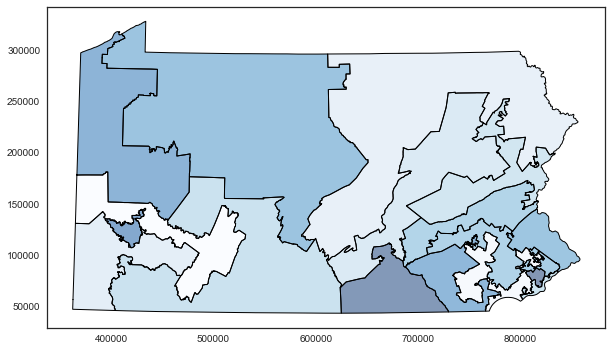

In [13]:
metrics[(metrics.usps == 'PA') & (metrics.year == 2010)].to_crs(epsg = 3364).plot(column = "obj_hull_pop", figsize = (10, 10), cmap = "Blues")
metrics[(metrics.usps == 'PA') & (metrics.year == 2010)][["cd", "pop_hull", "obj_hull_pop"]]

In [14]:
cols = ['usps', 'congress', 'year', 'cd', 'R_isoa', 'R_isop', 'R_LIC', 'R_SCC', 'R_mean', 'R_harm', 'R_dyn', 'pop', 'pop_hull', 'A_hull', 'IP_d', 'obj_ip_dist', 'obj_polsby', 'obj_lic', 'obj_scc', 'obj_inertia_a', 'obj_inertia_p', 'obj_mean_radius', 'obj_harm_radius', 'obj_dyn_radius', 'obj_axis', 'obj_hull_pop', 'obj_hull_area', 'obj_rohrbach']

# metrics[cols + ['geometry']].to_file("decennial_compactness.shp")
# metrics[cols].to_csv("decennial_compactness.csv", index = False)


In [4]:
compact = pd.read_csv("decennial_compactness.csv")
display(compact.sort_values(by = "obj_inertia_a", ascending = False))
metrics[(metrics.usps == 'PA') & (metrics.year == 2010)].sort_values(by = "obj_hull_pop", ascending = False)

,usps,congress,year,cd,R_isoa,R_isop,R_LIC,R_SCC,R_mean,R_harm,...,obj_scc,obj_inertia_a,obj_inertia_p,obj_mean_radius,obj_harm_radius,obj_dyn_radius,obj_axis,obj_hull_pop,obj_hull_area,obj_rohrbach
894,CA,114,2010,19,27567.017798,57547.827248,16295.709488,26131.168727,11240.284602,8720.967265,...,1.112915,2.132618,2.768517,1.635013,1.580502,1.481389,0.126456,0.799275,0.775458,0.558631
439,AZ,111,2000,5,34225.354041,68153.955540,23774.085330,36097.203577,14294.455667,11125.233431,...,0.898977,2.020341,3.207964,1.596206,1.538186,1.374444,0.159608,0.413068,0.677473,1.068517
32,CA,107,1990,16,28007.895860,51817.950612,16559.825006,37110.171126,12364.611081,9528.447478,...,0.569607,1.866204,2.066702,1.510111,1.469699,1.367333,0.284752,0.721632,0.791540,0.571574
44,CA,107,1990,28,19623.145886,41513.162436,11655.635952,17752.591819,9148.979918,7286.812869,...,1.221838,1.724130,1.722388,1.429897,1.346483,1.313224,0.204172,0.659003,0.749967,0.997518
39,CA,107,1990,23,38456.255745,65528.880010,31052.667947,40334.467978,22226.977305,19531.218102,...,0.909037,1.293625,1.757430,1.153441,0.984482,1.144795,0.222438,0.936517,0.860735,1.153000
949,FL,114,2010,9,39667.344518,68859.175564,26530.929518,38060.867069,23184.693801,20348.412967,...,1.086198,1.223413,1.809503,1.140619,0.974704,1.117041,0.201242,0.754209,0.800583,1.130150
960,FL,114,2010,20,47151.232803,100381.068714,35600.614773,55142.608210,31796.773520,27639.993537,...,0.731158,1.173815,1.193337,0.988596,0.852953,0.992032,0.424702,0.487733,0.739990,0.641033
487,CA,111,2000,41,104912.388149,157243.419803,75892.402864,142620.828710,70784.690101,60679.321272,...,0.541113,1.166990,2.802392,0.988089,0.864482,0.966023,0.259589,0.735337,0.863257,0.515303
902,CA,114,2010,27,24070.070123,49499.569820,14738.556763,29500.792360,14482.529542,11828.205390,...,0.665713,1.147285,1.700211,1.108005,1.017486,1.057429,0.185886,0.795580,0.757299,1.071890
87,FL,107,1990,7,29728.818428,69035.403420,20785.399814,40913.802635,18770.055756,15250.446929,...,0.527978,1.125282,0.689151,1.055895,0.974687,1.013559,0.146543,0.467891,0.755042,0.836940


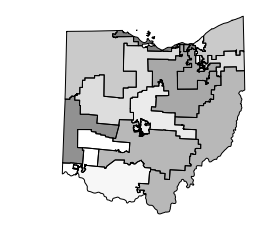

In [6]:
ax = cd_gdf.plot()
# tr_gdf.plot(color = "red", markersize = 1, ax = ax)
# tr_gdf.set_geometry("ctr").plot(color = "green", markersize = 5, ax = ax)
# tr_gdf.set_geometry("pctr").plot(color = "blue", markersize = 5, ax = ax)
# cd_gdf.geometry.apply(get_lic_circ).plot(ax = ax, cmap = "nipy_spectral")
# cd_gdf.convex_hull.intersection(state_mp).plot(ax = ax)
# tr_gdf.set_geometry("shape").plot(column = "dperim", linewidth = 0, cmap = "RdBu", alpha = 1, ax = ax)
# cd_gdf.boundary.plot(ax = ax, color = "white")
ax.set_axis_off()

#### The average distance between two points on a disk is 128 R / 45π.  Check this with MC -- looks good.

In [84]:
NMC = 50000
mat = np.random.rand(NMC, 2) * 2 - 1
mat = mat[(mat**2).sum(axis = 1) < 1,:]

dist2 = scipy.spatial.distance.cdist(mat, mat, metric = 'euclidean')

Ncirc = mat.shape[0]

print((dist2.sum() / Ncirc**2) / (128 / (45 * math.pi)))

1.00273304554
